In [1]:
import numpy as np
import math

import tensorflow as tf
import tensorflow_probability as tfp
import trieste
from trieste.data import Dataset

import timeit

import matplotlib.pyplot as plt

2021-11-16 15:58:25.416297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-16 15:58:25.416316: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-16 15:58:26.539165: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-16 15:58:26.563238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 15:58:26.563747: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 7.93GiB devi

In [2]:
# fancy code to import trieste notebook plotting utils
import importlib.util
spec = importlib.util.spec_from_file_location("plotting", "../docs/notebooks/util/plotting.py")
plotting = importlib.util.module_from_spec(spec)
spec.loader.exec_module(plotting)

from common_code import (
    SpecialSampler,
    SpecialBatchMonteCarloExpectedHypervolumeImprovement,
    create_empty_dataset,
    collect_initial_points,
    find_pf_points
)

In [3]:
OBJECTIVE = trieste.observer.OBJECTIVE
FAILURE = "FAILURE"

BATCH_SIZE = 1
ITERATIONS = 150

In [4]:
import gpflow
from trieste.models.gpflow import GPflowModelConfig

def create_regression_model(data, search_space):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance, lengthscales=[1.0]*int(search_space.dimension))
    scale = tf.constant(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.constant(-2.0, dtype=tf.float64), scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), scale
    )
    gpr = gpflow.models.GPR(data.astuple(), kernel)
    return gpr


def create_classification_model(data, search_space):
    kernel = gpflow.kernels.SquaredExponential(
        lengthscales=[1.0]*int(search_space.dimension)
    )
    scale = tf.constant(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.constant(-2.0, dtype=tf.float64), scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), scale
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    return vgp

classification_model_config_args = {
    "model_args": {"use_natgrads": True},
    "optimizer": tf.optimizers.Adam(1e-2),
    "optimizer_args": {"max_iter": 100},
}

## 1D case

In [5]:
search_space_1d = trieste.space.Box([0], [2*math.pi])

def func_1d(x):
    return tf.cos(2 * x) + tf.sin(x)

def failure_prob_func_1d(x):
    return 0.2 * (tf.cos(x) - tf.sin(x)) + 0.3

def observer_1d(x):
    all_datasets = {
        OBJECTIVE: create_empty_dataset(search_space_1d),
        FAILURE: create_empty_dataset(search_space_1d)
    }
        
    failure_probs = failure_prob_func_1d(x)
    random_draw = tf.random.uniform(tf.shape(failure_probs), dtype=tf.float64)
    
    x_ok = tf.reshape(tf.boolean_mask(x, random_draw >= failure_probs), (-1, 1))
    x_failed = tf.reshape(tf.boolean_mask(x, random_draw < failure_probs), (-1, 1))
    
    if len(x_failed) > 0:
        all_datasets[FAILURE] += Dataset(x_failed, tf.ones([tf.shape(x_failed)[0], 1], dtype=tf.float64))
    
    if len(x_ok) > 0:
        all_datasets[FAILURE] += Dataset(x_ok, tf.zeros([tf.shape(x_ok)[0], 1], dtype=tf.float64))
        all_datasets[OBJECTIVE] += Dataset(x_ok, tf.reshape(func_1d(x_ok), (-1, 1)))
    
    return all_datasets

In [6]:
num_initial_points_1d, initial_data_1d = collect_initial_points(search_space_1d, observer_1d, min_points=2)

Points in dataset OBJECTIVE: 2
Points in dataset FAILURE: 5


In [7]:
models_1d = {
    OBJECTIVE: GPflowModelConfig(**{
        "model": create_regression_model(initial_data_1d[OBJECTIVE], search_space_1d),
        "optimizer": gpflow.optimizers.Scipy(),
    }),
    FAILURE: GPflowModelConfig(
        create_classification_model(initial_data_1d[FAILURE], search_space_1d),
        **classification_model_config_args
    )
}

In [8]:
mc_ehvi = SpecialBatchMonteCarloExpectedHypervolumeImprovement(sample_size=5, gpr_tag=OBJECTIVE, vgp_tag=FAILURE)
rule = trieste.acquisition.rule.EfficientGlobalOptimization(mc_ehvi, num_query_points=BATCH_SIZE)


bo = trieste.bayesian_optimizer.BayesianOptimizer(observer_1d, search_space_1d)
start = timeit.default_timer()
result_1d = bo.optimize(ITERATIONS, initial_data_1d, models_1d, rule).final_result.unwrap()
stop = timeit.default_timer()

2021-11-16 15:58:26.877634: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-11-16 15:58:27.888125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-16 15:58:27.906825: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Optimization completed without errors


In [9]:
print(f"{stop - start:.2}s")

1.2e+03s


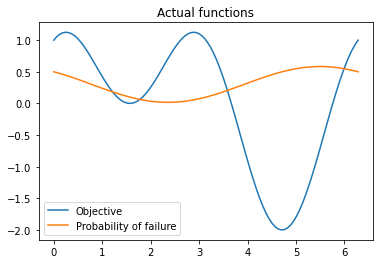

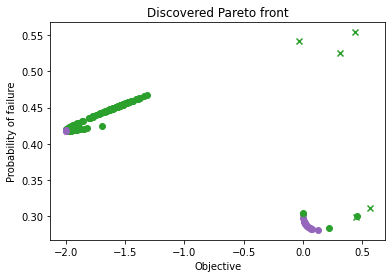

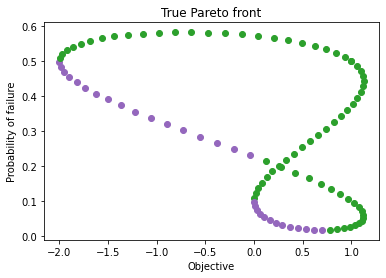

In [10]:
x_plot = np.linspace(start=search_space_1d.lower[0], stop=search_space_1d.upper[0], num=100)

plt.plot(x_plot, func_1d(x_plot), label="Objective");
plt.plot(x_plot, failure_prob_func_1d(x_plot), label="Probability of failure");
plt.legend();
plt.title("Actual functions");
plt.show();



all_query_points = result_1d.datasets[FAILURE].query_points
objective_model_values, _ = result_1d.models[OBJECTIVE].predict(all_query_points)
failure_model_values, _ = result_1d.models[FAILURE].predict_y(all_query_points)

points_in_objective_space = tf.concat([objective_model_values, failure_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points_1d)
plt.xlabel("Objective");
plt.ylabel("Probability of failure");
plt.title("Discovered Pareto front");
plt.show();



points_in_objective_space = tf.stack([func_1d(x_plot), failure_prob_func_1d(x_plot)], axis=-1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
plt.xlabel("Objective");
plt.ylabel("Probability of failure");
plt.title("True Pareto front");
plt.show();

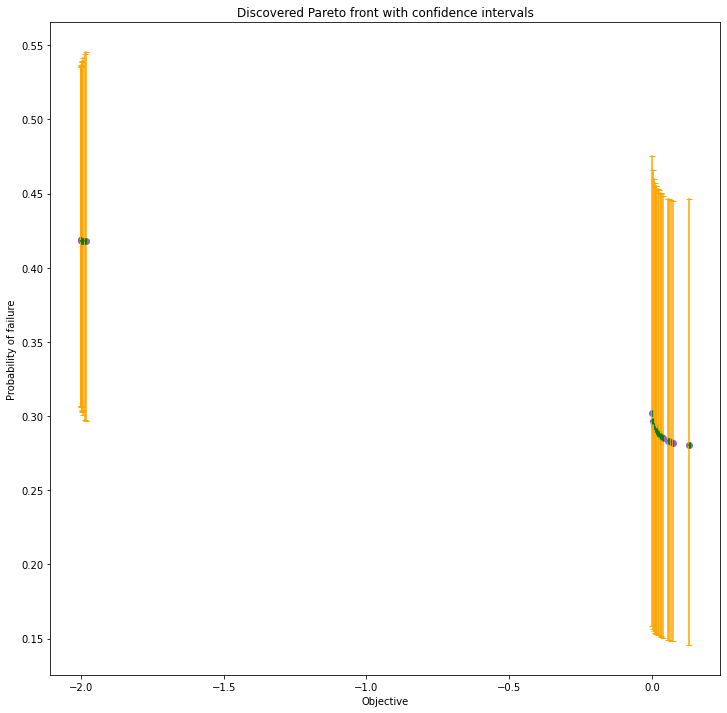

In [11]:
pf_input_points, pf_points = find_pf_points(all_query_points, objective_model_values, failure_model_values)
points_in_objective_space = tf.concat([objective_model_values, failure_model_values], axis=1)

mean, variance = result_1d.models[FAILURE].predict(pf_input_points)
failure_lower_conf_bounds = result_1d.models[FAILURE]._model.likelihood.invlink(mean - 2 * tf.sqrt(variance))
failure_upper_conf_bounds = result_1d.models[FAILURE]._model.likelihood.invlink(mean + 2 * tf.sqrt(variance))

mean, variance = result_1d.models[OBJECTIVE].predict(pf_input_points)
objective_lower_conf_bounds = mean - 2 * tf.sqrt(variance)
objective_upper_conf_bounds = mean + 2 * tf.sqrt(variance)

plotting.plot_mobo_points_in_obj_space(
    points_in_objective_space,
    num_init=num_initial_points_1d,
    only_plot_pareto=True,
    figsize=(12,12)
)

for i, (lower, upper) in enumerate(zip(failure_lower_conf_bounds, failure_upper_conf_bounds)):
    plt.plot((pf_points[i].numpy()[0], pf_points[i].numpy()[0]), (lower, upper), '_-',color='orange')

for i, (lower, upper) in enumerate(zip(objective_lower_conf_bounds, objective_upper_conf_bounds)):
    plt.plot((lower, upper), (pf_points[i].numpy()[1], pf_points[i].numpy()[1]), '|-',color='green')


plt.xlabel("Objective")
plt.ylabel("Probability of failure");
plt.title("Discovered Pareto front with confidence intervals");
plt.show();

## 2D case

In [12]:
search_space_2d = trieste.space.Box([0, 0], [2*math.pi, 2*math.pi])

def func_2d(input_data):
    x, y = input_data[..., -2], input_data[..., -1]
    z = tf.cos(2.0 * x) * tf.cos(y) + tf.sin(x)
    return z[:, None]

def failure_prob_func_2d(input_data):
    x, y = input_data[:, -2], input_data[:, -1]
    # changes are made so that the function is between 0 and 1
    z = 1.0 - (tf.cos(x) * tf.cos(y) - tf.sin(x) * tf.sin(y) + 1.0) / 2.0
    return z[:, None]

def observer_2d(x):
    all_datasets = {
        OBJECTIVE: create_empty_dataset(search_space_2d),
        FAILURE: create_empty_dataset(search_space_2d)
    }
        
    failure_probs = failure_prob_func_2d(x)
    random_draw = tf.random.uniform(tf.shape(failure_probs), dtype=tf.float64)
    
    x_ok = tf.gather(x, tf.where(random_draw >= failure_probs)[:, 0])
    x_failed = tf.gather(x, tf.where(random_draw < failure_probs)[:, 0])
    
    if len(x_failed) > 0:
        all_datasets[FAILURE] += Dataset(x_failed, tf.ones([tf.shape(x_failed)[0], 1], dtype=tf.float64))
    
    if len(x_ok) > 0:
        all_datasets[FAILURE] += Dataset(x_ok, tf.zeros([tf.shape(x_ok)[0], 1], dtype=tf.float64))
        all_datasets[OBJECTIVE] += Dataset(x_ok, tf.reshape(func_2d(x_ok), (-1, 1)))
    
    return all_datasets

In [13]:
num_initial_points_2d, initial_data_2d = collect_initial_points(search_space_2d, observer_2d, min_points=2)

Points in dataset OBJECTIVE: 2
Points in dataset FAILURE: 3


In [14]:
models_2d = {
    OBJECTIVE: GPflowModelConfig(**{
        "model": create_regression_model(initial_data_2d[OBJECTIVE], search_space_2d),
        "optimizer": gpflow.optimizers.Scipy(),
    }),
    FAILURE: GPflowModelConfig(
        create_classification_model(initial_data_2d[FAILURE], search_space_2d),
        **classification_model_config_args
    )
}

In [15]:
mc_ehvi = SpecialBatchMonteCarloExpectedHypervolumeImprovement(sample_size=5, gpr_tag=OBJECTIVE, vgp_tag=FAILURE)
rule = trieste.acquisition.rule.EfficientGlobalOptimization(mc_ehvi, num_query_points=BATCH_SIZE)


bo = trieste.bayesian_optimizer.BayesianOptimizer(observer_2d, search_space_2d)
start = timeit.default_timer()
result_2d = bo.optimize(ITERATIONS, initial_data_2d, models_2d, rule).final_result.unwrap()
stop = timeit.default_timer()

Optimization completed without errors


In [26]:
print(f"{stop - start:.2}s")

1.3e+03s


In [16]:
def plot_objective_and_failure():
    grid, xx, yy = plotting.create_grid(search_space_2d.lower, search_space_2d.upper, grid_density=80)
    objective = func_2d(grid).numpy()
    failure = failure_prob_func_2d(grid).numpy()
    fig, axes = plt.subplots(1, 2, sharex="all", sharey="all", figsize=(10, 6))

    levels = 30

    contourplot = axes[0].contourf(xx, yy, objective.reshape(*xx.shape), levels, alpha=0.9)
    plt.colorbar(contourplot, ax=axes[0])
    contourplot = axes[1].contourf(xx, yy, failure.reshape(*xx.shape), levels, alpha=0.9)
    plt.colorbar(contourplot, ax=axes[1])
    axes[0].set_title("Objective")
    axes[1].set_title("Probability of Failure")

    for ax in axes:
        ax.set_xlim(search_space_2d.lower[0], search_space_2d.upper[0])
        ax.set_ylim(search_space_2d.lower[1], search_space_2d.upper[1])

    return fig

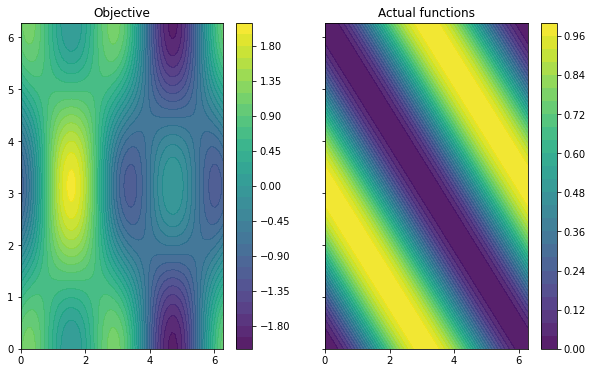

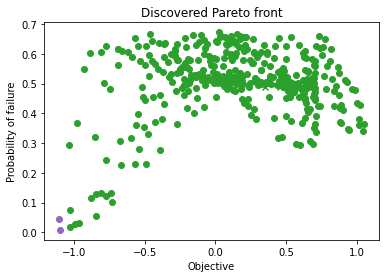

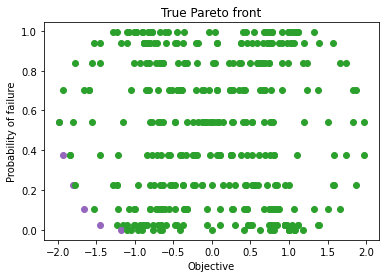

In [17]:
plot_objective_and_failure()
plt.title("Actual functions");
plt.show();

grid, xx, yy = plotting.create_grid(search_space_2d.lower, search_space_2d.upper, grid_density=20)


all_query_points = result_2d.datasets[FAILURE].query_points
objective_model_values, _ = result_2d.models[OBJECTIVE].predict(grid)
failure_model_values, _ = result_2d.models[FAILURE].predict_y(grid)

points_in_objective_space = tf.concat([objective_model_values, failure_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points_2d)
plt.xlabel("Objective");
plt.ylabel("Probability of failure");
plt.title("Discovered Pareto front");
plt.show();



points_in_objective_space = tf.concat([func_2d(grid), failure_prob_func_2d(grid)], axis=-1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
plt.xlabel("Objective");
plt.ylabel("Probability of failure");
plt.title("True Pareto front");
plt.show();


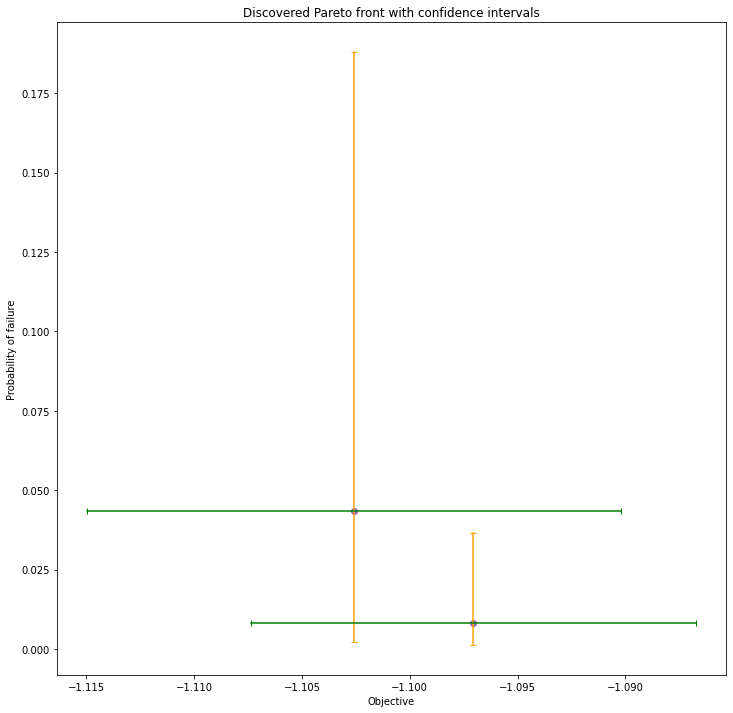

In [18]:
pf_input_points, pf_points = find_pf_points(grid, objective_model_values, failure_model_values)
points_in_objective_space = tf.concat([objective_model_values, failure_model_values], axis=1)

mean, variance = result_2d.models[FAILURE].predict(pf_input_points)
failure_lower_conf_bounds = result_2d.models[FAILURE]._model.likelihood.invlink(mean - 2 * tf.sqrt(variance))
failure_upper_conf_bounds = result_2d.models[FAILURE]._model.likelihood.invlink(mean + 2 * tf.sqrt(variance))

mean, variance = result_2d.models[OBJECTIVE].predict(pf_input_points)
objective_lower_conf_bounds = mean - 2 * tf.sqrt(variance)
objective_upper_conf_bounds = mean + 2 * tf.sqrt(variance)

plotting.plot_mobo_points_in_obj_space(
    points_in_objective_space,
    num_init=num_initial_points_2d,
    only_plot_pareto=True,
    figsize=(12,12)
)

for i, (lower, upper) in enumerate(zip(failure_lower_conf_bounds, failure_upper_conf_bounds)):
    plt.plot((pf_points[i].numpy()[0], pf_points[i].numpy()[0]), (lower, upper), '_-',color='orange')

for i, (lower, upper) in enumerate(zip(objective_lower_conf_bounds, objective_upper_conf_bounds)):
    plt.plot((lower, upper), (pf_points[i].numpy()[1], pf_points[i].numpy()[1]), '|-',color='green')


plt.xlabel("Objective")
plt.ylabel("Probability of failure");
plt.title("Discovered Pareto front with confidence intervals");
plt.show();

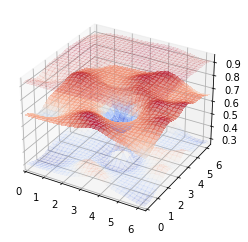

In [19]:
fig, ax = plotting.plot_gp_2d(
    result_2d.models[FAILURE].model,  # type: ignore
    search_space_2d.lower,
    search_space_2d.upper,
    grid_density=30,
    predict_y=True
)

## Train a VGP model a lot

In [20]:
_, training_data = collect_initial_points(search_space_2d, observer_2d, min_points=500)

Points in dataset OBJECTIVE: 500
Points in dataset FAILURE: 988


In [21]:
training_data = training_data[FAILURE]

In [22]:
test_model = trieste.models.config.create_model(GPflowModelConfig(
        create_classification_model(training_data, search_space_2d),
        **classification_model_config_args
    ))

In [23]:
test_model.update(training_data)
test_model.optimize(training_data)

In [24]:
test_model.model

name,class,transform,prior,trainable,shape,dtype,value
VGPWrapper.kernel.variance,Parameter,Softplus,LogNormal,True,(),float64,1.601293403740377
VGPWrapper.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(2,)",float64,[1.16582884 1.06443628]
VGPWrapper.data[0],ResourceVariable,,,False,"(None, 2)",float64,"[[2.65053266, 2.1880779..."
VGPWrapper.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[1....
VGPWrapper.q_mu,Parameter,Identity,,True,"(988, 1)",float64,[[-1.88173670e-01...
VGPWrapper.q_sqrt,Parameter,FillTriangular,,True,"(1, 988, 988)",float64,"[[[2.11439992e-01, 0.00000000e+00, 0.00000000e+00..."
VGPWrapper._num_data,ResourceVariable,,,False,(),float64,988.0


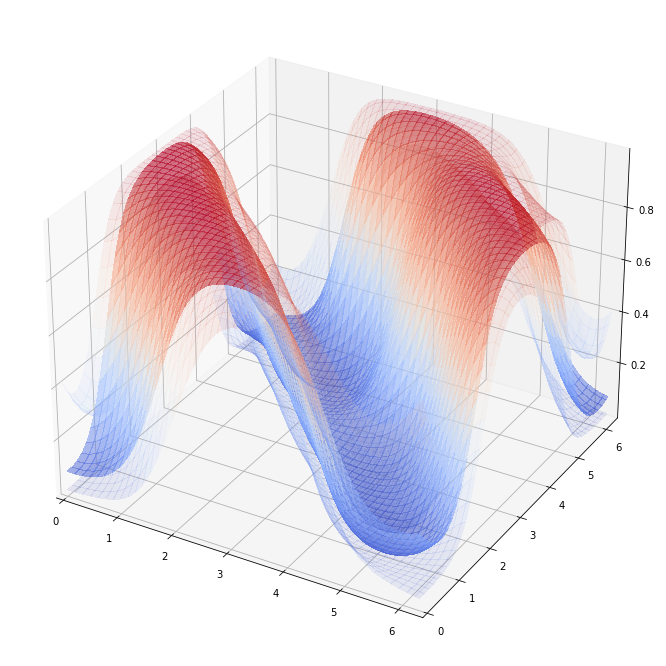

In [25]:
fig, ax = plotting.plot_gp_2d(
    test_model.model,  # type: ignore
    search_space_2d.lower,
    search_space_2d.upper,
    grid_density=90,
    predict_y=False,
    figsize=(12, 12)
)